In [1]:
!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import files

In [3]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

Saving departuredelays.csv to departuredelays.csv


In [4]:
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], format='%m%d%H%M', errors='coerce')
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
else:
    raise ValueError("Dataset does not contain a 'date' column.")

In [5]:
if 'delay' in df.columns:
    df['delayed'] = (df['delay'] > 15).astype(int)
else:
    raise ValueError("Dataset does not contain a 'delay' column.")

In [6]:
if 'origin' in df.columns:
    top_airports = df['origin'].value_counts().nlargest(2).index.tolist()
    print("Selected Airports:", top_airports)
else:
    raise ValueError("Dataset does not contain an 'origin' column.")

Selected Airports: ['ATL', 'DFW']



Processing Airport: ATL
Model Accuracy: 0.7353664535169699
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84     14116
           1       0.37      0.23      0.29      4181

    accuracy                           0.74     18297
   macro avg       0.58      0.56      0.56     18297
weighted avg       0.70      0.74      0.71     18297



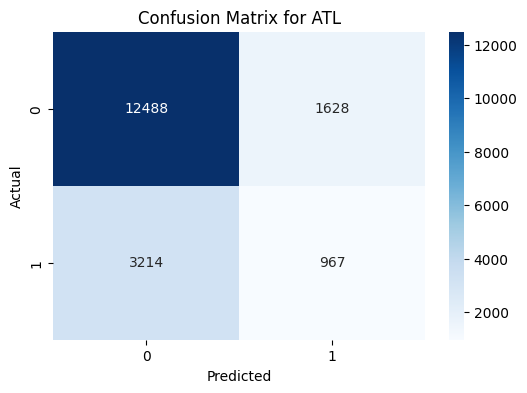

Model Accuracy applying SMOTE: 0.715636443132754
Classification Report applying SMOTE:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82     14116
           1       0.35      0.28      0.31      4181

    accuracy                           0.72     18297
   macro avg       0.57      0.56      0.57     18297
weighted avg       0.70      0.72      0.70     18297



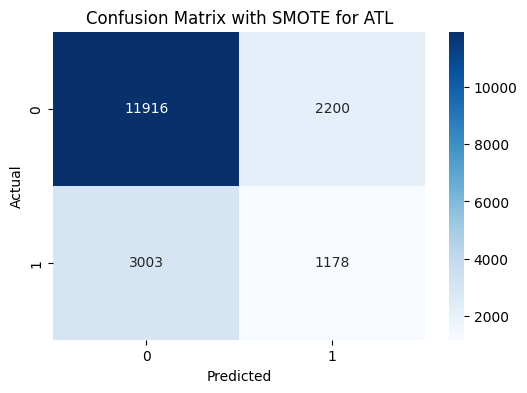

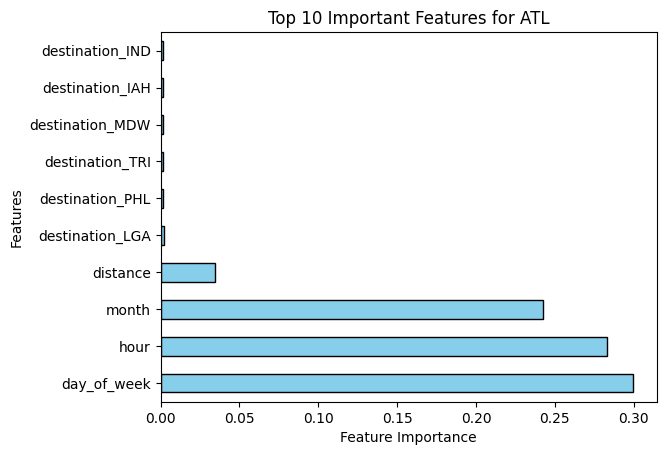


Processing Airport: DFW
Model Accuracy: 0.7441045484412645
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85     10866
           1       0.29      0.16      0.21      2831

    accuracy                           0.74     13697
   macro avg       0.55      0.53      0.53     13697
weighted avg       0.70      0.74      0.72     13697



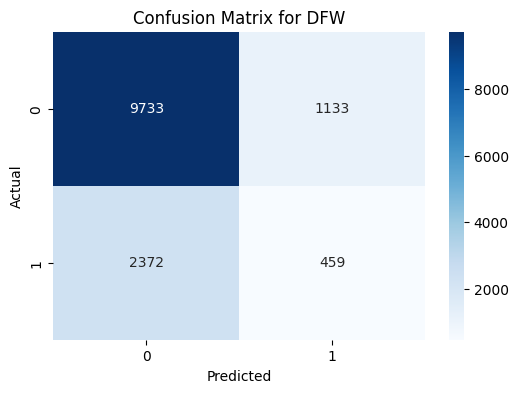

Model Accuracy applying SMOTE: 0.7246112287362196
Classification Report applying SMOTE:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83     10866
           1       0.28      0.22      0.25      2831

    accuracy                           0.72     13697
   macro avg       0.55      0.54      0.54     13697
weighted avg       0.70      0.72      0.71     13697



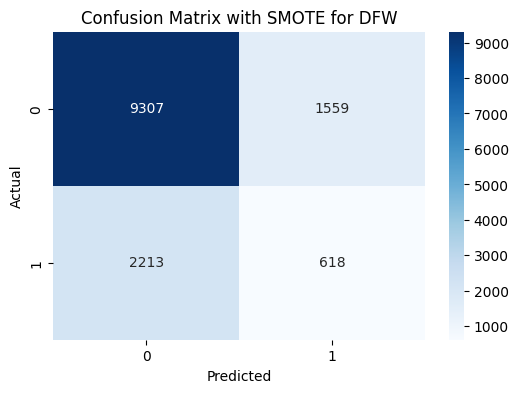

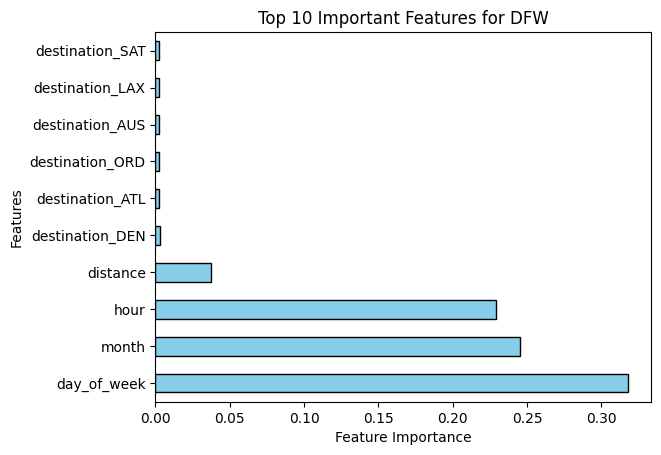

In [8]:
for airport in top_airports:
    print(f"\nProcessing Airport: {airport}")
    df_airport = df[df['origin'] == airport].copy()

    df_airport = pd.get_dummies(df_airport, columns=['destination'], drop_first=True)

    X = df_airport.drop(columns=['delay', 'date', 'delayed', 'origin'])
    y = df_airport['delayed']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if X_train.isnull().sum().sum() > 0:
        print("Warning: Missing values detected. Handling NaNs...")
        X_train.fillna(X_train.median(), inplace=True)
        X_test.fillna(X_test.median(), inplace=True)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy_before_smote = accuracy_score(y_test, y_pred)
    print("Model Accuracy:", accuracy_before_smote)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {airport}")
    plt.show()

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    model.fit(X_train_resampled, y_train_resampled)
    y_pred_resampled = model.predict(X_test)
    accuracy_after_smote = accuracy_score(y_test, y_pred_resampled)
    print("Model Accuracy applying SMOTE:", accuracy_after_smote)
    print("Classification Report applying SMOTE:\n", classification_report(y_test, y_pred_resampled))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_resampled), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix with SMOTE for {airport}")
    plt.show()

    feature_importance = pd.Series(model.feature_importances_, index=X.columns)
    feature_importance.nlargest(10).plot(kind='barh', color='skyblue', edgecolor='black')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Top 10 Important Features for {airport}")
    plt.show()

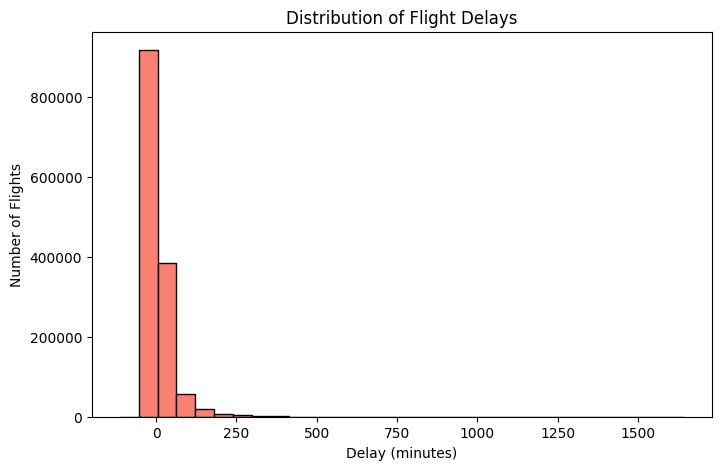

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(df['delay'], bins=30, color='salmon', edgecolor='black')
plt.xlabel("Delay (minutes)")
plt.ylabel("Number of Flights")
plt.title("Distribution of Flight Delays")
plt.show()